# **Introduction**



1. [Import data and python packages](#t1.)
2. [Assess Data Quality & Missing Values](#t2.)
    * 2.1. [Age - Missing Values](#t2.1.)
    * 2.2. [Cabin - Missing Values](#t2.2.)
    * 2.3. [Embarked - Missing Values](#t2.3.)
    * 2.4. [Final Adjustments to Data](#t2.4.)
        * 2.4.1 [Additional Variables](#t2.4.1.)
3. [Exploratory Data Analysis](#t3.)
4. [Logistic Regression and Results](#t4.)
5. [Decision Tree and Results](#t4.)
6. [Random  Forest and Results](#t4.)


<a id="t1."></a>
# 1. Import Data & Python Packages

In [82]:
import numpy as np 
import pandas as pd 

from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve,auc

In [83]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("titanic_train.csv")


# preview train data
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [84]:
train_df.shape

(891, 12)

Text(0, 0.5, 'count')

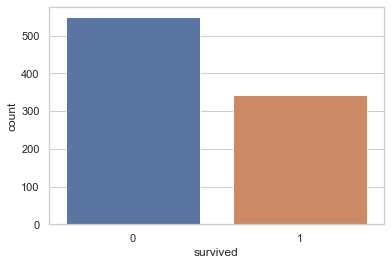

In [85]:
ax = sns.countplot(x='Survived', data=train_df)
ax.set_xlabel('survived')
ax.set_ylabel("count")  

In [86]:
print('The number of samples into the train data is {}.'.format(train_df.shape[0]))

The number of samples into the train data is 891.


In [87]:
# print('The number of samples into the test data is {}.'.format(test_df.shape[0]))

<font color=red>  Note: there is no target variable into test data (i.e. "Survival" column is missing), so the goal is to predict this target using different machine learning algorithms such as logistic regression. </font>

<a id="t2."></a>
# 2. Data Quality & Missing Value Assessment

In [88]:
# check missing values in train data
train_df.isnull().sum() / train_df.shape[0] * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

<a id="t2.1."></a>
## 2.1.    Age - Missing Values

In [89]:
# percent of missing "Age" 
print('Percent of missing "Age" records is %.2f%%' %((train_df['Age'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Age" records is 19.87%


~20% of entries for passenger age are missing. Let's see what the 'Age' variable looks like in general.

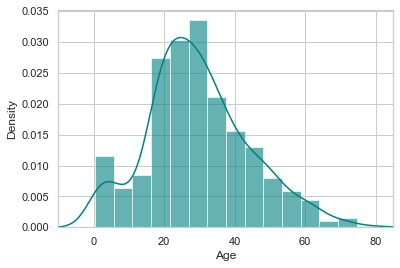

In [90]:
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

Since "Age" is (right) skewed, using the mean might give us biased results by filling in ages that are older than desired. To deal with this, we'll use the median to impute the missing values. 

In [91]:
# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))

The mean of "Age" is 29.70
The median of "Age" is 28.00


<a id="t2.2."></a>
## 2.2. Cabin - Missing Values

In [92]:
# percent of missing "Cabin" 
print('Percent of missing "Cabin" records is %.2f%%' %((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Cabin" records is 77.10%


77% of records are missing, which means that imputing information and using this variable for prediction is probably not wise.  We'll ignore this variable in our model.

<a id="t2.3."></a>
## 2.3. Embarked - Missing Values

In [93]:
# percent of missing "Embarked" 
print('Percent of missing "Embarked" records is %.2f%%' %((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


There are only 2 (0.22%) missing values for "Embarked", so we can just impute with the port where most people boarded.

Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
S    644
C    168
Q     77
Name: Embarked, dtype: int64


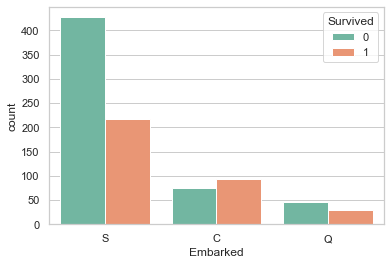

In [94]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', hue='Survived', data=train_df, palette='Set2')
plt.show()

In [95]:
print('The most common boarding port of embarkation is %s.' %train_df['Embarked'].value_counts().idxmax())

The most common boarding port of embarkation is S.


By far the most passengers boarded in Southhampton, so we'll impute those 2 NaN's w/ "S".

<a id="t2.4."></a>
## 2.4. Final Adjustments to Data (Train)

Based on my assessment of the missing values in the dataset, I'll make the following changes to the data:
* If "Age" is missing for a given row, I'll impute with 28 (median age).
* If "Embarked" is missing for a riven row, I'll impute with "S" (the most common boarding port).
* I'll ignore "Cabin" as a variable. There are too many missing values for imputation. Based on the information available, it appears that this value is associated with the passenger's class and fare paid.

In [96]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna=True), inplace=True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace=True)
train_data.drop('Cabin', axis=1, inplace=True)

In [97]:
# check missing values in adjusted train data
train_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [98]:
# preview adjusted train data
train_data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked'],
      dtype='object')

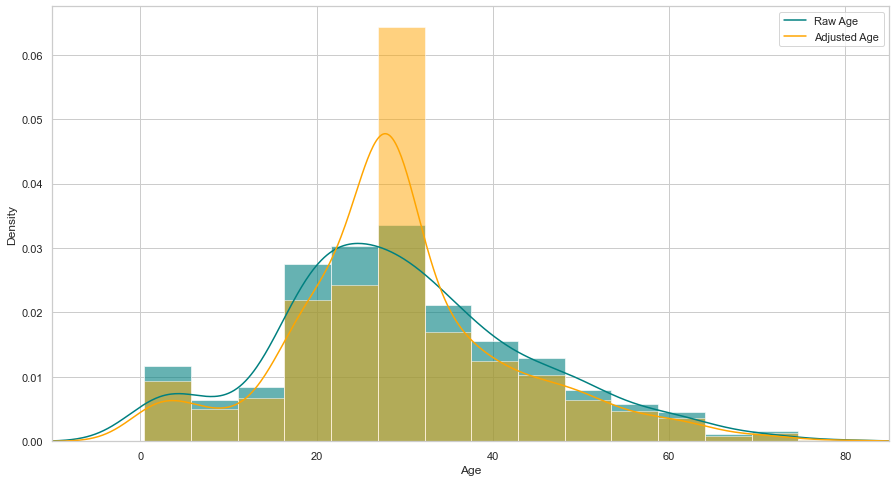

In [99]:
plt.figure(figsize=(15,8))
ax = train_df["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax = train_data["Age"].hist(bins=15, density=True, stacked=True, color='orange', alpha=0.5)
train_data["Age"].plot(kind='density', color='orange')
ax.legend(['Raw Age', 'Adjusted Age'])
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

<a id="t2.4.1."></a>
## 2.4.1. Additional Variables

According to the Kaggle data dictionary, both SibSp and Parch relate to traveling with family.  For simplicity's sake (and to account for possible multicollinearity), I'll combine the effect of these variables into one categorical predictor: whether or not that individual was traveling alone.

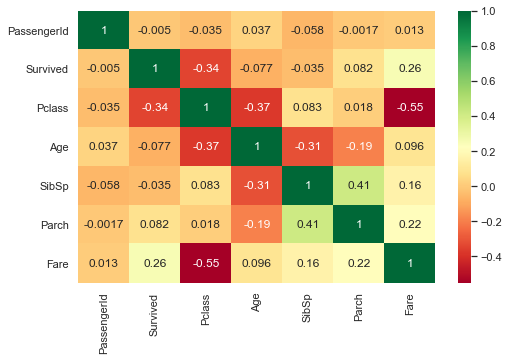

In [100]:
plt.subplots(figsize=(8, 5))
sns.heatmap(train_df.corr(), annot=True, cmap="RdYlGn")
plt.show()

In [101]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [102]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [103]:
## Create categorical variable for traveling alone
train_data['TravelAlone']=np.where((train_data["SibSp"]+train_data["Parch"])>0, 0, 1)
train_data.drop('SibSp', axis=1, inplace=True)
train_data.drop('Parch', axis=1, inplace=True)

I'll also create categorical variables for Passenger Class ("Pclass"), Gender ("Sex"), and Port Embarked ("Embarked"). 

In [104]:
#create categorical variables and drop some variables
training=pd.get_dummies(train_data, columns=["Pclass","Embarked","Sex"])

# training.drop('Sex', axis=1, inplace=True)
training.drop('PassengerId', axis=1, inplace=True)
training.drop('Name', axis=1, inplace=True)
training.drop('Ticket', axis=1, inplace=True)

final_train = training
final_train.head()


,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,0,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,1,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,0,1



I will apply to same imputation for "Age" in the Test data as I did for my Training data (if missing, Age = 28).  <br> I'll also remove the "Cabin" variable from the test data, as I've decided not to include it in my analysis. <br> There were no missing values in the "Embarked" port variable. <br> I'll add the dummy variables to finalize the test set.  <br> Finally, I'll impute the 1 missing value for "Fare" with the median, 14.45.

In [105]:
final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,0,22.0,7.2500,0,0,0,1,0,0,1,0,1
1,1,38.0,71.2833,0,1,0,0,1,0,0,1,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,1,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,1,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,0,1


<a id="t3."></a>
# 3. Exploratory Data Analysis

<a id="t3.1."></a>
## 3.1. Exploration of Age

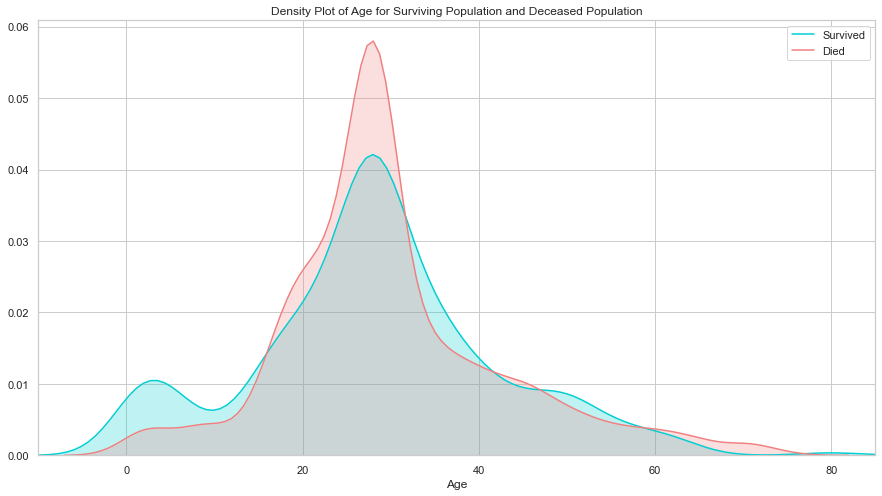

In [106]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Age"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Age"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Age for Surviving Population and Deceased Population')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

The age distribution for survivors and deceased is actually very similar.  One notable difference is that, of the survivors, a larger proportion were children.  The passengers evidently made an attempt to save children by giving them a place on the life rafts. 

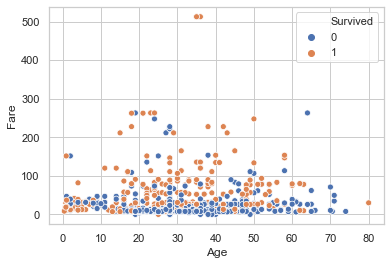

In [107]:
# plt.figure(figsize=(20,8))
# avg_survival_byage = final_train[["Age", "Survived"]].groupby(['Age'], as_index=False).mean()
# g = sns.barplot(x='Age', y='Survived', data=avg_survival_byage, color="LightSeaGreen")
# plt.show()

ax = sns.scatterplot(x="Age", y="Fare", hue='Survived', data=final_train)

Considering the survival rate of passengers under 16, I'll also include another categorical variable in my dataset: "Minor"

In [108]:
final_train['IsMinor']=np.where(final_train['Age']<=16, 1, 0)



<a id="t3.2."></a>
## 3.2. Exploration of Fare

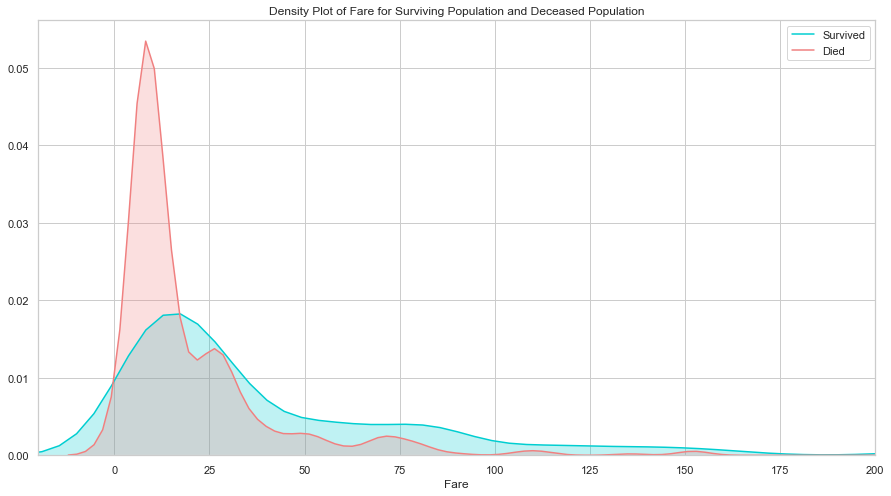

In [109]:
plt.figure(figsize=(15,8))
ax = sns.kdeplot(final_train["Fare"][final_train.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(final_train["Fare"][final_train.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')
ax.set(xlabel='Fare')
plt.xlim(-20,200)
plt.show()

As the distributions are clearly different for the fares of survivors vs. deceased, it's likely that this would be a significant predictor in our final model.  Passengers who paid lower fare appear to have been less likely to survive.  This is probably strongly correlated with Passenger Class, which we'll look at next.

<a id="t3.3."></a>
## 3.3. Exploration of Passenger Class

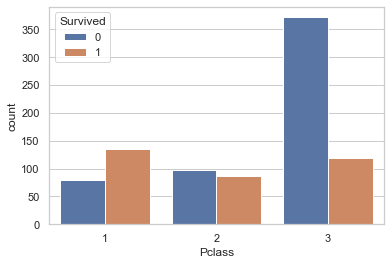

In [110]:
ax = sns.countplot(x="Pclass", hue='Survived',data=train_df)

Unsurprisingly, being a first class passenger was safest.

In [111]:
train_df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

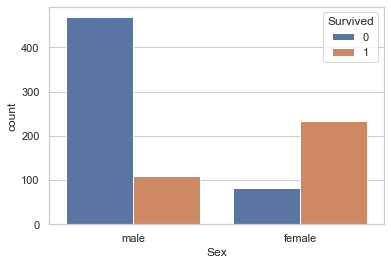

In [112]:
ax = sns.countplot(x="Sex", hue='Survived',data=train_df)

<a id="t3.4."></a>
## 3.4. Exploration of Embarked Port

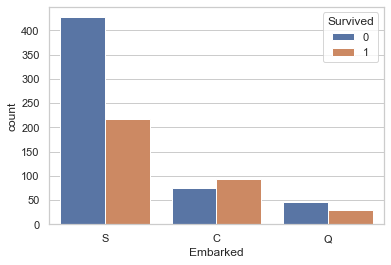

In [113]:
ax = sns.countplot(x="Embarked", hue='Survived', data=train_df)

Passengers who boarded in Cherbourg, France, appear to have the highest survival rate.  Passengers who boarded in Southhampton were marginally less likely to survive than those who boarded in Queenstown.  This is probably related to passenger class, or maybe even the order of room assignments (e.g. maybe earlier passengers were more likely to have rooms closer to deck). <br> It's also worth noting the size of the whiskers in these plots.  Because the number of passengers who boarded at Southhampton was highest, the confidence around the survival rate is the highest.  The whisker of the Queenstown plot includes the Southhampton average, as well as the lower bound of its whisker.  It's possible that Queenstown passengers were equally, or even more, ill-fated than their Southhampton counterparts.

<a id="t3.5."></a>
## 3.5. Exploration of Traveling Alone vs. With Family

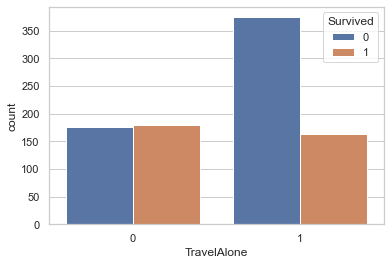

In [114]:
ax = sns.countplot(x="TravelAlone", hue='Survived', data=final_train)

Individuals traveling without family were more likely to die in the disaster than those with family aboard. Given the era, it's likely that individuals traveling alone were likely male.

<a id="t3.6."></a>
## 3.6. Exploration of Gender Variable

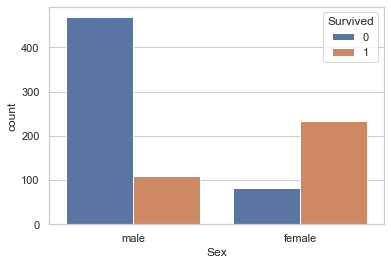

In [115]:
ax = sns.countplot(x="Sex", hue='Survived', data=train_df)

This is a very obvious difference.  Clearly being female greatly increased your chances of survival.

<a id="t4."></a>
# 4. Logistic Regression and Results

As we see, eight variables were kept. 

In [116]:
# Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
#                      'Embarked_S', 'Sex_male']# 'IsMinor']
# X = final_train[Selected_features]

# plt.subplots(figsize=(8, 5))
# sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
# plt.show()

<a id="t4.2."></a>
## 4.2. Review of model evaluation procedures

Motivation: Need a way to choose between machine learning models
* Goal is to estimate likely performance of a model on out-of-sample data

Initial idea: Train and test on the same data
* But, maximizing training accuracy rewards overly complex models which overfit the training data

Alternative idea: Train/test split
* Split the dataset into two pieces, so that the model can be trained and tested on different data
* Testing accuracy is a better estimate than training accuracy of out-of-sample performance
* Problem with train/test split
    * It provides a high variance estimate since changing which observations happen to be in the testing set can significantly change testing accuracy
    * Testing accuracy can change a lot depending on a which observation happen to be in the testing set

Reference: <br>
http://www.ritchieng.com/machine-learning-cross-validation/ <br>

<a id="t4.2.1."></a>
### 4.2.1. Model evaluation based on simple train/test split using `train_test_split()` function

In [117]:
 final_train.head()

,Survived,Age,Fare,TravelAlone,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,IsMinor
0,0,22.0,7.2500,0,0,0,1,0,0,1,0,1,0
1,1,38.0,71.2833,0,1,0,0,1,0,0,1,0,0
2,1,26.0,7.9250,1,0,0,1,0,0,1,1,0,0
3,1,35.0,53.1000,0,1,0,0,0,0,1,1,0,0
4,0,35.0,8.0500,1,0,0,1,0,0,1,0,1,0


In [118]:

Selected_features = ['Age', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Embarked_C', 
                     'Embarked_Q', 'Sex_female', 'IsMinor']
# create X (features) and y (response)
X = final_train[Selected_features]
y = final_train['Survived']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)


In [119]:
# Fitting Logistic Regression to the Training set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)


LogisticRegression(random_state=0)

In [120]:
      
# Making the Confusion Matrix
def get_metrics(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    

    class_names=[0,1] # name  of classes
    
    
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')


    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print(" True positive rate or (Recall or Sensitivity) :",metrics.recall_score(y_test, y_pred))

    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)

    #Specitivity. or True negative rate
    print(" True Negative rate or Specitivity :",specificity)

    false_negative = fn / (fn+tp)

    #False negative rate
    print(" False Negative rate :",false_negative)

    #False positive rate
    print(" False positive rate (Type 1 error) :",1 - specificity)
    print(cm)


def get_auc_score(y_test ,y_pred):
    r_a_score = roc_auc_score(y_test,y_pred)
    print("ROC-AUC-Score:", r_a_score)
    
def plot_roc_curve(y_test,y_pred,label=None):
#     # compute true positive rate and false positive rate
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#     # plotting them against each other
#     #def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
#     plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
#     plt.plot([0, 1], [0, 1], 'r', linewidth=4)
#     plt.axis([0, 1, 0, 1])
#     plt.xlabel('False Positive Rate (FPR)', fontsize=16)
#     plt.ylabel('True Positive Rate (TPR)', fontsize=16)

#     plt.figure(figsize=(14, 7))
#     plot_roc_curve(false_positive_rate, true_positive_rate)
#     plt.show()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
def get_accuracy_error(y_test,y_pred,label):
    print(label + " Accuracy:",metrics.accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    print(label + " Error:", (fp+fn)/(tn+ fp+ fn+ tp) ) 

Accuracy: 0.7877094972067039
Precision: 0.8360655737704918
 True positive rate or (Recall or Sensitivity) : 0.6455696202531646
 True Negative rate or Specitivity : 0.9
 False Negative rate : 0.35443037974683544
 False positive rate (Type 1 error) : 0.09999999999999998
[[90 10]
 [28 51]]


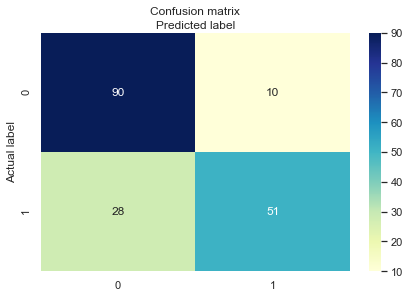

In [121]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
get_metrics(y_test,y_pred)

# Predicting on new data

In [122]:
temp = final_train[Selected_features].head(1)
temp['Age'] = 15
temp['Sex_female'] = 1

temp

,Age,TravelAlone,Pclass_1,Pclass_2,Embarked_C,Embarked_Q,Sex_female,IsMinor
0,15,0,0,0,0,0,1,0


In [123]:
classifier.predict(temp.values)

array([1], dtype=int64)

**********************
Logistic Regression Feature Importance
**********************


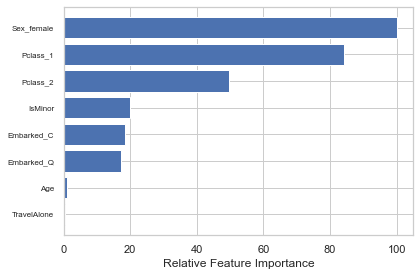

In [124]:

print('**********************')
print("Logistic Regression Feature Importance")
print('**********************')
feature_importance = abs(classifier.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()


In [125]:
# temp = pd.DataFrame(y_test)
# temp.Survived.value_counts()

Accuracy: 0.7877094972067039
Precision: 0.8360655737704918
 True positive rate or (Recall or Sensitivity) : 0.6455696202531646
 True Negative rate or Specitivity : 0.9
 False Negative rate : 0.35443037974683544
 False positive rate (Type 1 error) : 0.09999999999999998
[[90 10]
 [28 51]]


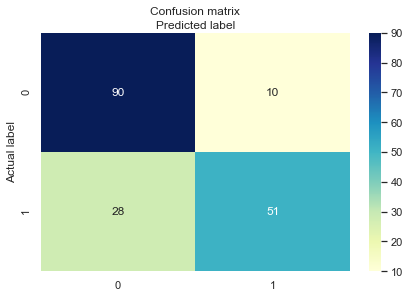

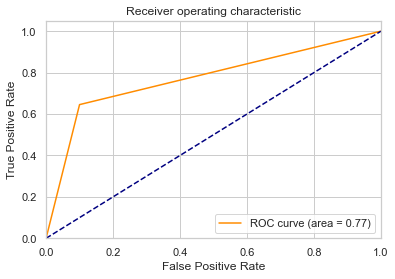

ROC-AUC-Score: 0.7727848101265822


In [126]:
get_metrics(y_test,y_pred)
plot_roc_curve(y_test,y_pred)
get_auc_score(y_test ,y_pred)

# Decision Tree

In [127]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
# import pydotplus
# import pydot

# Create decision tree classifer object
clf = DecisionTreeClassifier(random_state=0, max_depth = 4, min_samples_split = 100, min_samples_leaf = 50)
print(clf)
# Train model
model = clf.fit(X, y)
# Predicting the Test set results
y_pred = clf.predict(X_test)


DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, min_samples_split=100,
                       random_state=0)


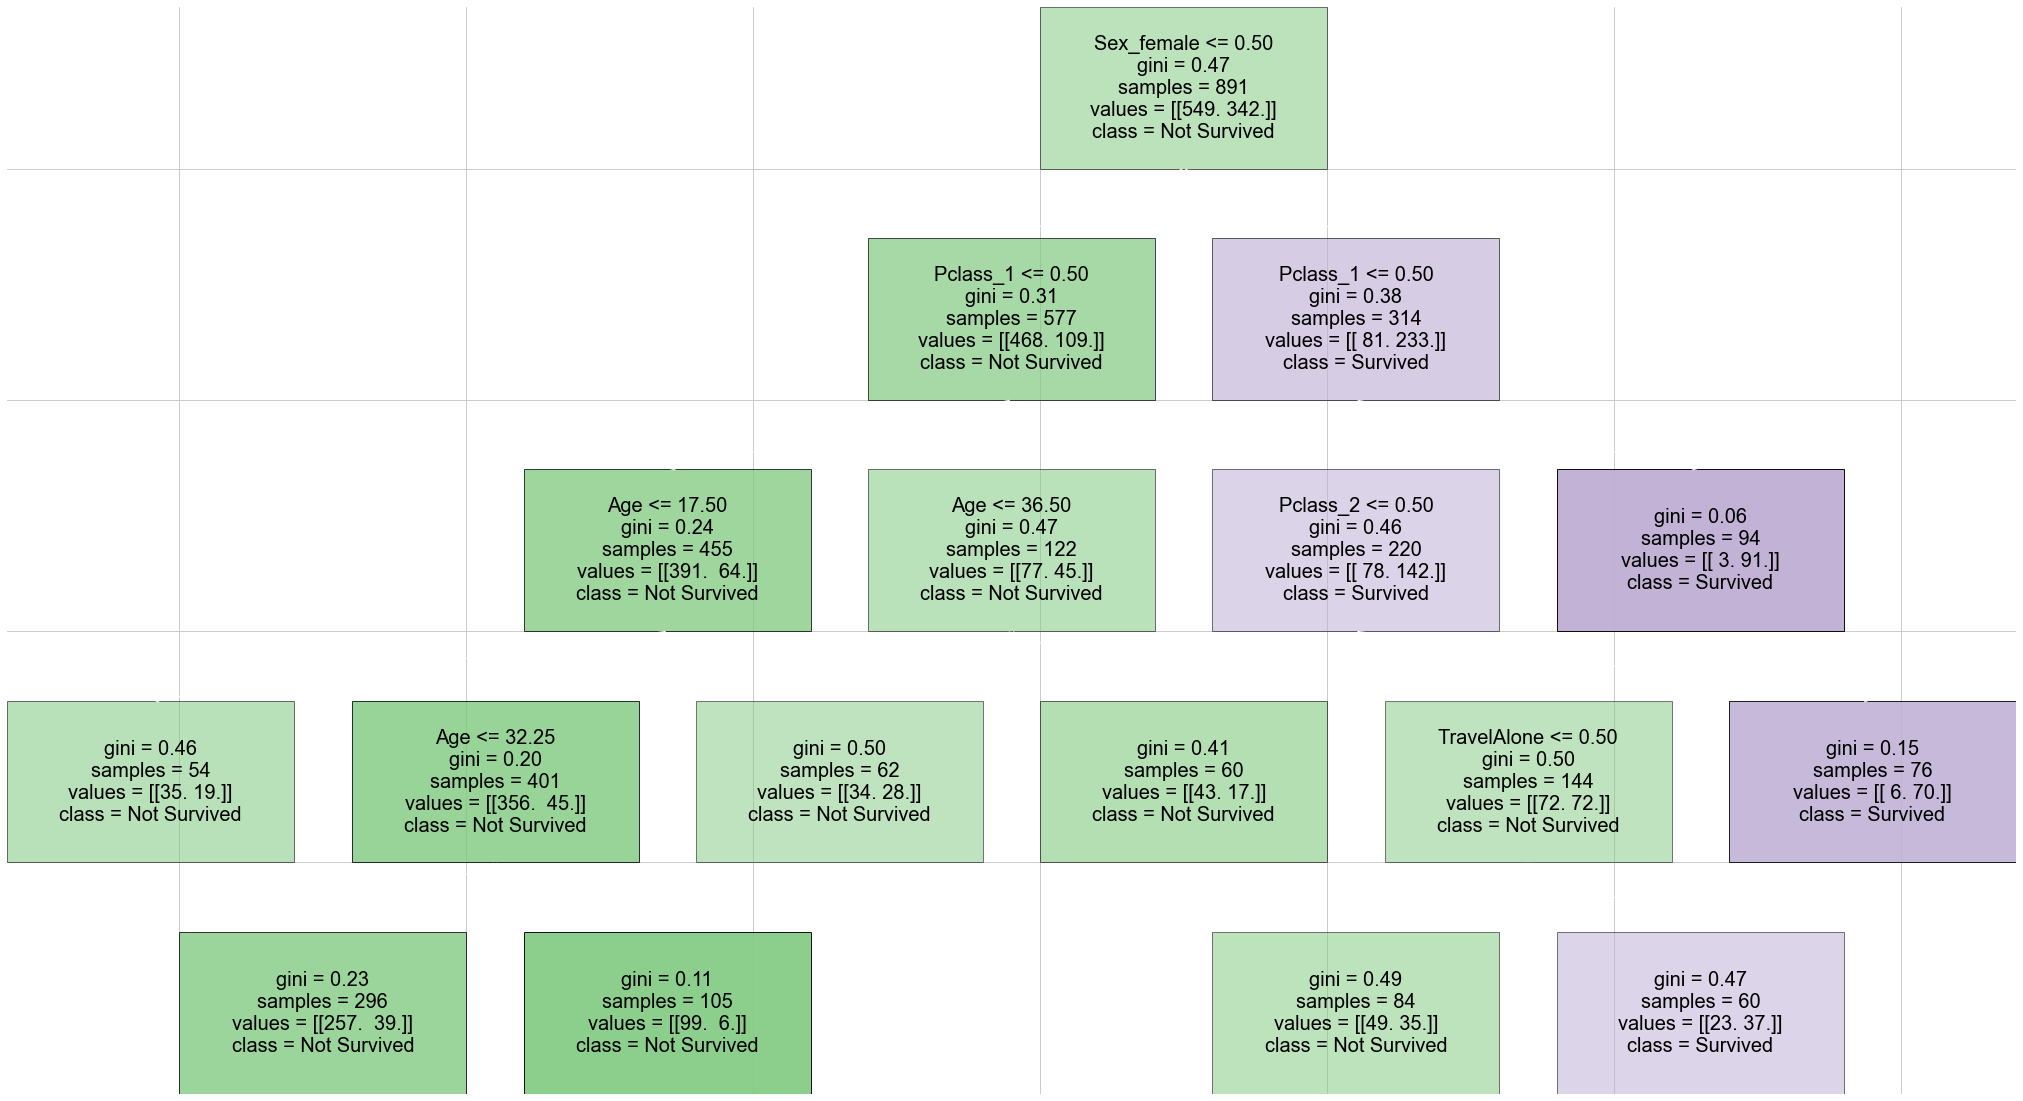

In [128]:
# from graphviz import Source
# graph = Source( tree.export_graphviz(clf, out_file=None, feature_names=X.columns, filled=True,
#                                     class_names=['Not Survived', 'Survived']))
# png_bytes = graph.pipe(format='png')
# with open('dtree_pipe.png','wb') as f:
#     f.write(png_bytes)

# from IPython.display import Image
# Image(png_bytes)

# # Creating decision tree plot
# from dtreeplt import dtreeplt
from dtreeplt import dtreeplt
dtree = dtreeplt(
    model=clf,
    feature_names=Selected_features,
    target_names=['Not Survived', 'Survived']
)
fig = dtree.view()

Accuracy: 0.776536312849162
Precision: 0.9534883720930233
 True positive rate or (Recall or Sensitivity) : 0.5189873417721519
 True Negative rate or Specitivity : 0.98
 False Negative rate : 0.4810126582278481
 False positive rate (Type 1 error) : 0.020000000000000018
[[98  2]
 [38 41]]


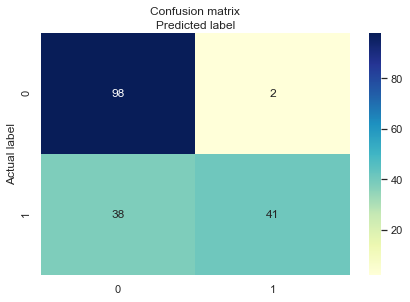

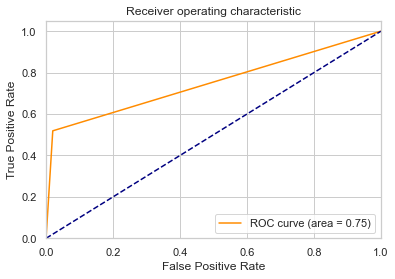

ROC-AUC-Score: 0.749493670886076


In [129]:
get_metrics(y_test,y_pred)
plot_roc_curve(y_test,y_pred)
get_auc_score(y_test ,y_pred)

# Random Forest

In [130]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_depth=4,
                             random_state=0, min_samples_leaf=10, min_samples_split=5)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

Accuracy: 0.7653631284916201
Precision: 0.8627450980392157
 True positive rate or (Recall or Sensitivity) : 0.5569620253164557
 True Negative rate or Specitivity : 0.93
 False Negative rate : 0.4430379746835443
 False positive rate (Type 1 error) : 0.06999999999999995
[[93  7]
 [35 44]]


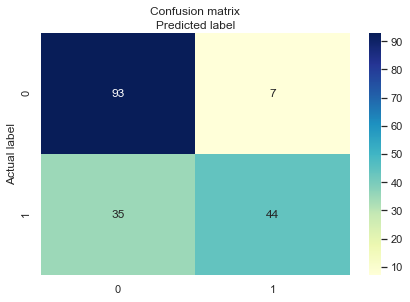

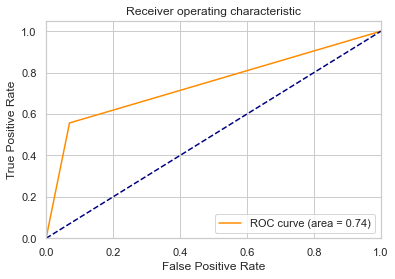

ROC-AUC-Score: 0.7434810126582276


In [131]:
get_metrics(y_test,y_pred)
plot_roc_curve(y_test,y_pred)
get_auc_score(y_test ,y_pred)

In [137]:

# save the model to disk
import pickle
filename = 'rf_model.h5'
# pickle.dump(rf, open(filename, 'wb'))

import joblib
joblib.dump(rf, filename)
loaded_model = joblib.load(filename)
# # some time later...
 
# # load the model from disk
# loaded_model = pickle.load(open(filename, 'rb'))
# loaded_model
loaded_model.predict(X_test)
result = loaded_model.score(X_test, y_test)
print(result)

0.7653631284916201


In [138]:
loaded_model

RandomForestClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=5,
                       random_state=0)

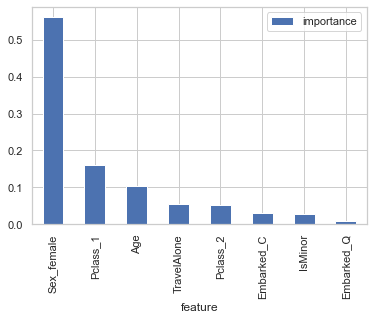

In [132]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)
importances.plot.bar()

# SVM

In [133]:
from sklearn import svm
print('**********************')
print("SVM")
print('**********************')

svm = svm.SVC( C= 2, gamma=2)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
svm

**********************
SVM
**********************


SVC(C=2, gamma=2)

Accuracy: 0.7541899441340782
Precision: 0.8181818181818182
 True positive rate or (Recall or Sensitivity) : 0.569620253164557
 True Negative rate or Specitivity : 0.9
 False Negative rate : 0.43037974683544306
 False positive rate (Type 1 error) : 0.09999999999999998
[[90 10]
 [34 45]]


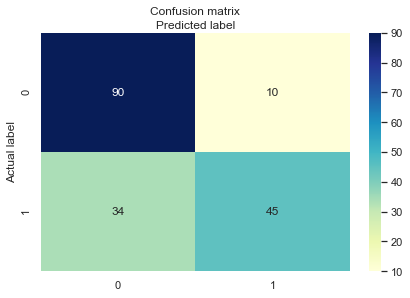

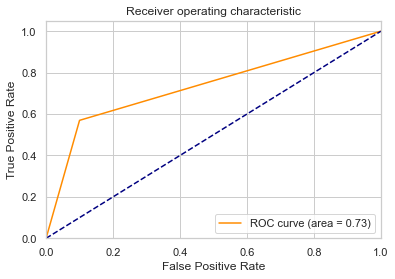

ROC-AUC-Score: 0.7348101265822785


In [134]:
get_metrics(y_test,y_pred)
plot_roc_curve(y_test,y_pred)
get_auc_score(y_test ,y_pred)